# Analisi dei Commenti dei Post

Questo notebook esplora le dinamiche dei commenti dei post, con particolare attenzione alla presenza di commenti negativi e alla loro eventuale dipendenza dai commenti precedenti.

## Obiettivi

L'obiettivo principale è **verificare se la presenza di commenti negativi successivi dipende dai commenti negativi iniziali**. In altre parole, vogliamo testare:

- * di studio:la L’ordine di comparsa di un gruppo di commenti negativi iniziali 
sotto un post, influenza la probabilità di trovare maggiori commenti negativ 
successivi sotto lo stesso po.stPrima di effettuare i test statistici viene fatto un test **Shapiro-Wilk** per verificare la distribuzione dei dati.

Dopo vengono usati:plementari:  

1. **Correlazione di Spearman** – per misurare l’associazione monotona tra percentuale di commenti negativi nei primi `first` commenti e la presenza di commenti negativi successivi.  
2. **Chi² e Cramer's V** – per valutare l’associazione in tabelle 2×2 tra la presenza di commenti negativi iniziali e successivi, confrontando i dati osservati con quelli attesi sotto H₀.

L’idea è che se i test confermano un’associazione significativa (Chi² elevato, Cramer’s V > 0, correlazione Spearman signifiipotesi nulla** e **acdi lavoropotesi alternativa**.

## Struttura del Notebook

* [Post informations extractions](#post-informations) – Estrazione dei dati dai post e preparazione del dataset.  
* [Check shape distribution](#distribution) – Analisi della distribuzione dei commenti per dimensio
   e caratteristiche.  
* [Spearman correlation](#Spearman) – Calcolo della correlazione tra percentuali di commenti negativi e success
  i commenti negativi.  
* [Chi² and Cramer's V](#Chi2) – Analisi delle associazioni tra commenti iniziali e successivi mediante test Chi-quadrato e misura di associazione Cramer’s V.
adrato e misura di associazione Cramer’s V.


In [1]:
import re
import json
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt


import random
from datetime import datetime
from collections import defaultdict, Counter
from scipy.stats import shapiro, skew, kurtosis, spearmanr

In [2]:
type_dataset = 'food'
platform = 'IG'
category = 'General'

path = r"C:\Users\naomi\Documents\tesi 2025\prova ufficiale\dataset\\"
outpath = r"C:\Users\naomi\Documents\tesi 2025\prova ufficiale\statistiche\\"

In [3]:
with open(path + f'{category}_{platform}.json', 'r', encoding = 'utf-8') as f:
    dataset = json.load(f)

### Post informations

Per ogni account vengono raccolte informazioni sui post pubblicati. La chiave di ogni post porta con sé:
1. 'label': etichetta il post come **_positivo_** o **_negativo_**
2. 'n_comments': numero di commenti validi per ogni post
3. 'perc_positive_comments': percentule di commenti positivi
4. 'perc_negative_comments': percentuale di commenti negativi
5. 'lst_comments': la lista delle label di ogni commento

Per svolgere queste analisi, i commenti NEUTRI non sono stati presi in considerazione. 

In [4]:
# Raccogli i sentiment score
sentiment_scores = []
for account, posts in dataset.items():
    for post_id, post_info in posts.items():
        for interaction in post_info.get('interactions_post', []):
            score = interaction.get('sentiment', {}).get('score')
            if isinstance(score, (int, float)):
                sentiment_scores.append(score)

# Crea i bin
df = pd.DataFrame({'sentiment_score': sentiment_scores})
sentiment_bins = pd.cut(df['sentiment_score'], bins=3)
bin_edges = sentiment_bins.cat.categories
sentiment_labels = ['negative', 'neutral', 'positive']

In [5]:
from collections import defaultdict, Counter
import json
from datetime import datetime

def analyze_posts(dataset, path, output_file, bin_edges):

    post_informations = defaultdict(lambda: defaultdict(lambda: {
        'n_comments': 0,              
        'sentiment_cats': Counter(),  
        'lst_comments': []            
    }))

    for account_name, posts in dataset.items():
        for post_id, post_data in posts.items():
        
            for interaction in post_data.get('interactions_post', []):
                author = interaction.get('user_name')
                comment = interaction.get('comment', '')
                data_str = interaction.get('data')  # formato: YYYY/MM/DD

                if not author or not comment.strip() or comment.strip().isdigit():
                    continue

                sentiment_score = interaction.get('sentiment', {}).get('score')

                # classificazione preliminare
                label = None
                if sentiment_score is not None:
                    if sentiment_score <= bin_edges[0].right:
                        label = 'negative'
                    elif sentiment_score <= bin_edges[1].right:
                        label = 'neutral'
                    else:
                        label = 'positive'

                if label == 'neutral' or label is None:
                    continue

                # aggiorna dati post
                post_info = post_informations[account_name][post_id]
                post_info['n_comments'] += 1
                post_info['sentiment_cats'][label] += 1

                # salvo (data, label) per ordinamento
                # data_str ha formato "YYYY/MM/DD"
                try:
                    y, m, d = map(int, data_str.split("/"))
                    sort_key = (d, m, y)  # ordine: giorno, mese, anno
                except Exception:
                    sort_key = (9999, 9999, 9999)  # fallback se manca la data

                post_info['lst_comments'].append((sort_key, label))

    # costruzione output finale
    output_data = {}
    for account_name, posts in post_informations.items():
        output_data[account_name] = {}
        for post_id, data in posts.items():
            n_comments = data['n_comments']
            
            # ordino per giorno, mese, anno e salvo solo le label
            lst_comments = [
                lbl for _, lbl in sorted(data['lst_comments'], key=lambda x: x[0])
            ]
            
            neg = data['sentiment_cats'].get('negative', 0)
            pos = data['sentiment_cats'].get('positive', 0)

            perc_neg = neg / n_comments if n_comments > 0 else 0
            perc_pos = pos / n_comments if n_comments > 0 else 0

            if perc_neg > perc_pos:
                node_label = 'negative'
            elif perc_neg < perc_pos:
                node_label = 'positive'
            else:  
                avg_hate = round(sum(data.get('hate_scores', [])) / len(data.get('hate_scores', [1])), 4)
                node_label = 'negative' if avg_hate > 0.2 else 'positive'

            output_data[account_name][post_id] = {
                'label': node_label,
                'n_comments': n_comments,
                'perc_positive_comments': perc_pos,
                'perc_negative_comments': perc_neg,
                'lst_comments': lst_comments  # SOLO label ordinate per giorno, mese, anno
            }

    with open(path + output_file, 'w', encoding='utf-8') as jsonfile:
        json.dump(output_data, jsonfile, ensure_ascii=False, indent=2)

    print(f"✅ File salvato in formato JSON: {output_file}")


In [6]:
analyze_posts(dataset, outpath, f'post_key_LABEL_{category}_{platform}.json', bin_edges)

✅ File salvato in formato JSON: post_key_LABEL_General_IG.json


In [3]:
with open(outpath + f'post_key_LABEL_{category}_{platform}.json', 'r', encoding = 'utf-8') as f:
    post_informations = json.load(f)

### Distribution

n_comments -> media: 34.94840790004031
dev std: 12.276490186135709
skewness: -0.3166622220745202
kurtosis: -0.16313269990649504
Shapiro-Wilk statistic: 0.9881342053413391 p-value: 8.401828945383648e-31
→ I dati NON seguono una distribuzione normale


C:\Users\naomi\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


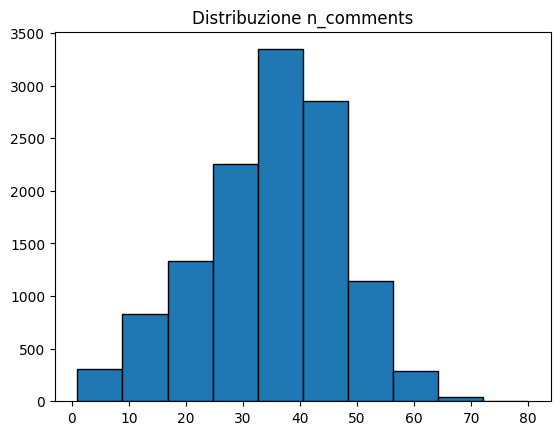

In [8]:
# Flatten del dizionario annidato
values = []
for account, posts in post_informations.items():
    for post_id, info in posts.items():
        values.append({
            "n_comments": info["n_comments"],
            "perc_positive": info["perc_positive_comments"],
            "perc_negative": info["perc_negative_comments"]
        })

# Estraggo una variabile da analizzare, ad esempio n_comments
n_comments = [v["n_comments"] for v in values]
perc_pos = [v["perc_positive"] for v in values]
perc_neg = [v["perc_negative"] for v in values]

# Statistiche descrittive
print("n_comments -> media:", sum(n_comments)/len(n_comments))
print("dev std:", (sum((x - sum(n_comments)/len(n_comments))**2 for x in n_comments)/len(n_comments))**0.5)
print("skewness:", skew(n_comments))
print("kurtosis:", kurtosis(n_comments))

# Test di Shapiro-Wilk
stat, p = shapiro(n_comments)
print("Shapiro-Wilk statistic:", stat, "p-value:", p)
if p > 0.05:
    print("→ I dati sembrano normali")
else:
    print("→ I dati NON seguono una distribuzione normale")

# Istogramma
plt.hist(n_comments, bins=10, edgecolor='black')
plt.title("Distribuzione n_comments")
plt.show()


### Spearman

In [4]:
def real_and_random_correlation_with_pvalue(post_informations, first=13, n_sim=1000):
    """
    Calcola la correlazione reale tra percentuale di commenti negativi
    e nuovo commento negativo, confrontandola con simulazioni casuali
    e calcolando un p-value empirico.
    """
    # --- 1. Correlazione reale ---
    X_cont_real = []
    Y_real = []

    for _, post_key in post_informations.items():
        for _, data in post_key.items():
            comments = [c for c in data['lst_comments'] if c in ("positive","negative")]
            if len(comments) < first:
                continue
            first_comments = comments[:first]
            remaining_comments = comments[first:]

            neg = sum(1 for c in first_comments if c=="negative")
            tot = len(first_comments)
            if tot == 0:
                continue

            neg_per = neg / tot
            new_neg_bin = 1 if any(c=="negative" for c in remaining_comments) else 0

            X_cont_real.append(neg_per)
            Y_real.append(new_neg_bin)

    X_cont_real = np.array(X_cont_real)
    Y_real = np.array(Y_real)

    corr_real, _ = spearmanr(X_cont_real, Y_real)

    # --- 2. Simulazioni casuali ---
    all_comments = []
    for _, post_key in post_informations.items():
        for _, data in post_key.items():
            all_comments.extend([c for c in data['lst_comments'] if c in ("positive","negative")])

    n_posts = len(X_cont_real)
    n_comments_first = first
    random_corrs = []

    for _ in range(n_sim):
        sampled_posts = []
        for _ in range(n_posts):
            sampled_first = random.choices(all_comments, k=n_comments_first)
            sampled_remaining = random.choices(all_comments, k=random.randint(0, n_comments_first))
            neg = sum(1 for c in sampled_first if c=="negative")
            tot = len(sampled_first)
            if tot == 0:
                continue
            neg_per = neg / tot
            new_neg_bin = 1 if any(c=="negative" for c in sampled_remaining) else 0
            sampled_posts.append((neg_per, new_neg_bin))

        if sampled_posts:
            X_sim, Y_sim = zip(*sampled_posts)
            corr_sim, _ = spearmanr(X_sim, Y_sim)
            random_corrs.append(corr_sim)

    # --- 3. Calcolo p-value empirico ---
    random_corrs = np.array(random_corrs)
    p_empirical = np.mean(random_corrs >= corr_real)

    # --- 4. Visualizzazione ---
#    plt.figure(figsize=(8,5))
#    plt.hist(random_corrs, bins=30, alpha=0.7, color='skyblue', label='Simulazioni casuali')
#    plt.axvline(corr_real, color='red', linestyle='--', linewidth=2, label=f'Correlazione reale = {corr_real:.3f}')
#    plt.xlabel("Correlazione Spearman")
#    plt.ylabel("Frequenza")
#    plt.title("Distribuzione correlazioni casuali vs reale")
#    plt.legend()
#    plt.show()

    return corr_real, random_corrs, p_empirical

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_corr_vs_first(post_informations, first_values, type_dataset, category ,platform, n_sim=500, save_path=None):
    """
    For each value of `first` in the list first_values:
    - compute corr_real and random_corrs
    - collect corr_real and mean of random_corrs
    - then generate two plots:
        1. real correlation vs first
        2. mean random correlation vs first
    """
    corrs_real = []
    corrs_random_mean = []
    p_empirics = []
    
    # Crea la cartella se non esiste
    if save_path:
        os.makedirs(save_path, exist_ok=True)
    
    for f in first_values:
        corr_real, random_corrs, p_empirical = real_and_random_correlation_with_pvalue(
            post_informations, first=f, n_sim=n_sim
        )
        corrs_real.append(corr_real)
        corrs_random_mean.append(np.mean(random_corrs))
        p_empirics.append(p_empirical)
        print(f"first: {f}  --  Real: {corr_real}")
        print(f"first: {f}  --  Random: {np.mean(random_corrs)}\n")
        
    # Plot real correlation vs first
    plt.figure(figsize=(8,5))
    plt.plot(first_values, corrs_real, marker='o', color='red', label='Real correlation')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Number of initial comments (first)")
    plt.ylabel("Spearman correlation (real)")
    plt.title("Real correlation vs first")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}/{type_dataset}_{category}_{platform}_real_correlation_vs_first.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot mean random correlation vs first
    plt.figure(figsize=(8,5))
    plt.plot(first_values, corrs_random_mean, marker='o', color='blue', label='Mean random correlations')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Number of initial comments (first)")
    plt.ylabel("Mean of random correlations")
    plt.title("Mean random correlations vs first")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}/{type_dataset}_{category}_{platform}_mean_random_correlation_vs_first.png", dpi=300, bbox_inches='tight')
    plt.show()


first: 5  --  Real: 0.1023043091871876
first: 5  --  Random: -7.553678268908223e-06

first: 7  --  Real: 0.11540852526066403
first: 7  --  Random: 0.000285968271607387

first: 11  --  Real: 0.14181377167953552
first: 11  --  Random: 0.00016175369719614434

first: 13  --  Real: 0.15115570241532456
first: 13  --  Random: 0.0005431231940867949

first: 17  --  Real: 0.15359501632495226
first: 17  --  Random: -0.0004543799031377096

first: 19  --  Real: 0.1561217511981701
first: 19  --  Random: -5.973294231103103e-05

first: 23  --  Real: 0.18235249041906426
first: 23  --  Random: 0.00035863034590882147

first: 29  --  Real: 0.19228349619880059
first: 29  --  Random: -0.00011524889675283181

first: 43  --  Real: 0.22234736097451616
first: 43  --  Random: -0.0001044706383732571



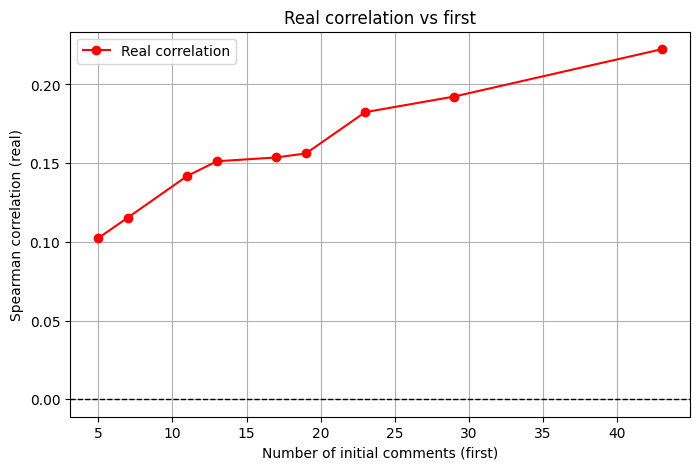

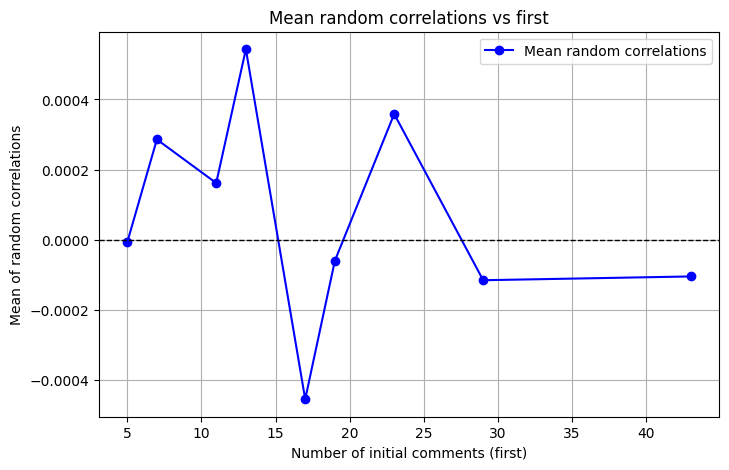

In [6]:
first_values = [5, 7, 11, 13, 17, 19, 23, 29, 43]
plot_corr_vs_first(post_informations, first_values, type_dataset, category ,platform, n_sim=1000, save_path='fig_result')


### Chi2

In [12]:
def valori_osservati(post_informations, threshold=0.15, first=13):
    """
    Calcola una matrice globale 2x2 osservata.
    Righe = condizione (above threshold / sotto threshold)
    Colonne = nuovo commento (positivo/negativo)
    
    Ritorna:
    - matrix_counts: matrice con i conteggi
    - matrix_perc: matrice con percentuali
    - diagnostics: informazioni sull'esecuzione
    """
    matrix_counts = np.zeros((2, 2), dtype=int)

    n_posts_used = 0
    n_posts_above = 0
    n_posts_below = 0

    for _, post_key in post_informations.items():
        for _, data in post_key.items():
            lst_comments = data['lst_comments']
            if len(lst_comments) <= first:
                continue  # niente commenti da processare dopo i primi `first`

            # Conta i primi commenti
            first_check = lst_comments[:first]
            pos = sum(1 for com in first_check if com == "positive")
            neg = sum(1 for com in first_check if com == "negative")
            tot_comment = pos + neg
            if tot_comment == 0:
                continue  # nessun commento positivo/negativo nei primi `first`

            neg_per = neg / tot_comment
            above = neg_per >= threshold
            if above:
                n_posts_above += 1
            else:
                n_posts_below += 1

            # Processa i commenti rimanenti
            processed_any = False
            for lbl in lst_comments[first:]:
                if lbl not in ("positive", "negative"):
                    continue  # ignora neutrali
                processed_any = True
                if lbl == "positive" and above:
                    matrix_counts[0, 0] += 1
                elif lbl == "positive" and not above:
                    matrix_counts[0, 1] += 1
                elif lbl == "negative" and above:
                    matrix_counts[1, 0] += 1
                    neg += 1
                elif lbl == "negative" and not above:
                    matrix_counts[1, 1] += 1
                    neg += 1

                tot_comment += 1
                neg_per = neg / tot_comment
                above = neg_per >= threshold

            if processed_any:
                n_posts_used += 1  # conto solo i post che hanno influenzato la matrice

    # Matrice in percentuali
    total = matrix_counts.sum()
    matrix_perc = matrix_counts / total if total > 0 else np.zeros_like(matrix_counts, dtype=float)

    diagnostics = {
        "n_posts_used": n_posts_used,
        "n_posts_above": n_posts_above,
        "n_posts_below": n_posts_below,
        "total_comments": total
    }

    return matrix_counts, matrix_perc, diagnostics


In [13]:
matrix_counts, matrix_perc, diagnostics = valori_osservati(post_informations, threshold=0.15, first=13)

In [14]:
def chi2_2x2(matrice):
    """
    Analisi chi-quadrato per tabella 2x2.
    Input:
        matrice: lista o array 2x2 di conteggi osservati
    Restituisce:
        - frequenze attese (E)
        - residui standardizzati
        - chi2
        - Cramer's V
    """
    O = np.array(matrice, dtype=float)

    # totali
    tot_gen = O.sum()
    tot_riga = O.sum(axis=1)
    tot_col = O.sum(axis=0)

    # frequenze attese
    E = np.array([[tot_riga[0]*tot_col[0]/tot_gen, tot_riga[0]*tot_col[1]/tot_gen],
                  [tot_riga[1]*tot_col[0]/tot_gen, tot_riga[1]*tot_col[1]/tot_gen]])

    # residui standardizzati
    residui_std = (O - E) / np.sqrt(E)

    # chi-quadrato
    chi2 = ((O - E)**2 / E).sum()

    # Cramer's V (misura di associazione)
    cramers_v = np.sqrt(chi2 / (tot_gen * (min(O.shape)-1)))
        # stampa ordinata
      #  print("=== Analisi Chi-quadrato 2x2 ===")
     #   print("Osservati (O):\n", O)
    #    print("\nFrequenze attese (E):\n", np.round(E, 2))
   #     print("\nResidui standardizzati:\n", np.round(residui_std, 2))
  #      print(f"\nChi2 = {chi2:.3f}")
 #       print(f"Cramer's V = {cramers_v:.3f}")
 #       print("================================")

    return E, residui_std, chi2, cramers_v

In [15]:
def display_chi2_cramer(post_informations, thresholds, first_values):
    """
    Calcola Chi2 e Cramer's V per tutte le combinazioni di threshold e first,
    utilizzando la funzione valori_osservati e chi2_2x2.
    
    Restituisce un DataFrame con colonne:
    ['threshold', 'first', 'chi2', 'cramers_v']
    """
    results = []

    for t in thresholds:
        for f in first_values:
            # ottieni matrice di conteggi osservati
            matrix_counts, _, _ = valori_osservati(post_informations, threshold=t, first=f)

            # calcola chi2 e cramers V
            _, _, chi2, cramers_v = chi2_2x2(matrix_counts)

            results.append({
                'threshold': t,
                'first': f,
                'chi2': chi2,
                'cramers_v': cramers_v
            })

    df = pd.DataFrame(results)
    return df


In [16]:
def pivot_chi2_cramer(post_informations, thresholds, first_values):
    """
    Calcola Chi2 e Cramer's V per tutte le combinazioni di threshold e first,
    e restituisce due pivot table (per heatmap) con righe=threshold, colonne=first.
    """
    results = []

    for t in thresholds:
        for f in first_values:
            # ottieni matrice di conteggi osservati
            matrix_counts, _, _ = valori_osservati(post_informations, threshold=t, first=f)
            
            # calcola chi2 e cramers V
            _, _, chi2, cramers_v = chi2_2x2(matrix_counts)
            
            results.append({'threshold': t, 'first': f, 'chi2': chi2, 'cramers_v': cramers_v})
    
    df = pd.DataFrame(results)
    
    # pivot table per heatmap
    chi2_pivot = df.pivot(index='threshold', columns='first', values='chi2')
    cramers_pivot = df.pivot(index='threshold', columns='first', values='cramers_v')
    
    return chi2_pivot, cramers_pivot


In [17]:
thresholds = [0.05, 0.15, 0.25, 0.5, 0.6]
first_values = [5, 7, 13, 19, 23, 43, 53, 73]

chi2_pivot, cramers_pivot = pivot_chi2_cramer(post_informations, thresholds, first_values)

print("Chi2 pivot table:\n", chi2_pivot)
print("\nCramer's V pivot table:\n", cramers_pivot)


C:\Users\naomi\AppData\Local\Temp\ipykernel_25252\3617553551.py:24: RuntimeWarning: invalid value encountered in divide
  residui_std = (O - E) / np.sqrt(E)
C:\Users\naomi\AppData\Local\Temp\ipykernel_25252\3617553551.py:27: RuntimeWarning: invalid value encountered in divide
  chi2 = ((O - E)**2 / E).sum()


Chi2 pivot table:
 first                5             7             13            19  \
threshold                                                           
0.05        6253.866567   5615.039985   4300.128822   3539.754269   
0.15       14607.764779  14058.411884  11574.712089   9175.890238   
0.25       21590.124462  20531.384099  17664.200737  14071.762370   
0.50       22735.330934  22066.621521  18634.499240  14708.966461   
0.60       17091.593799  16599.185229  13852.396567  10863.979169   

first                23           43          53       73  
threshold                                                  
0.05        3017.334030   911.062484  309.766594      NaN  
0.15        7723.008600  1737.531835  513.214170  7.21875  
0.25       11696.372960  2301.594439  607.085223  7.21875  
0.50       12136.921095  2329.051687  642.639610  7.21875  
0.60        8995.834063  1870.292251  547.886251  7.21875  

Cramer's V pivot table:
 first            5         7         13        19  

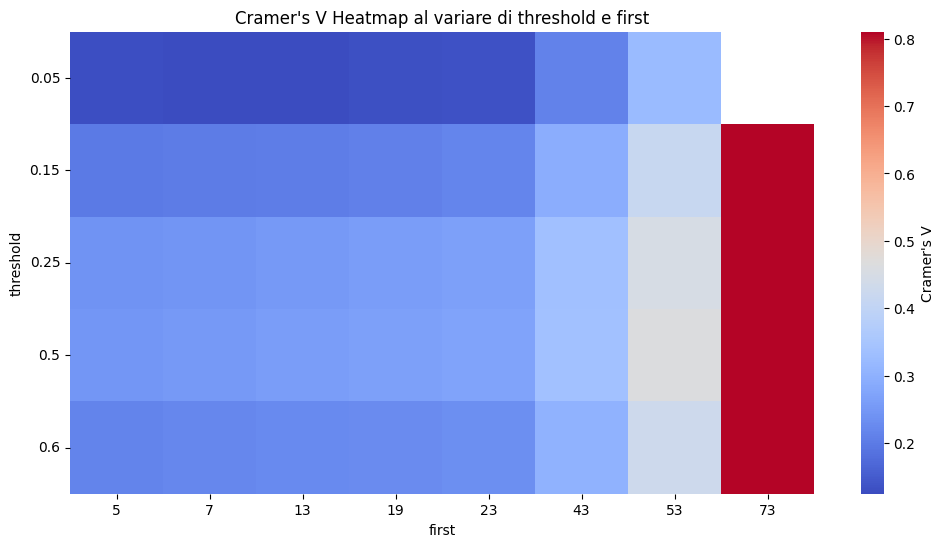

In [18]:
plt.figure(figsize=(12, 6))
sns.heatmap(cramers_pivot, annot=False, fmt=".3f", cmap="coolwarm", cbar_kws={'label': "Cramer's V"})
plt.title("Cramer's V Heatmap al variare di threshold e first")
plt.xlabel("first")
plt.ylabel("threshold")
plt.yticks(rotation=0)  # mantiene i threshold leggibili
plt.show()
